<h1>Comments on Notebook</h1>
<p>This is finall starting to look good. Note to self: this is the right direction</p>


In [2]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# Directory containing the images
image_dir = '../Data/HAM/ham_images'

# Load the dataset
data = pd.read_csv('../Data/HAM/HAM10000_metadata.csv')

# Image size (for resizing)
image_size = (128, 128)

# Function to load and preprocess images using OpenCV
def load_and_preprocess_images_cv(df, image_dir, image_size):
    images = []
    labels = []
    missing_images = []
    for idx, row in df.iterrows():
        img_path = os.path.join(image_dir, f"{row['image_id']}.jpg")
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.resize(img, image_size)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
            labels.append(row['dx'])
        else:
            missing_images.append(img_path)
    images = np.array(images, dtype='float32') / 255.0  # Normalize images
    return images, labels, missing_images

# Load and preprocess the images
images, labels, missing_images = load_and_preprocess_images_cv(data, image_dir, image_size)

# Check if there are missing images
if missing_images:
    print(f"Missing images: {len(missing_images)}")
    for img in missing_images[:10]:  # Display up to 10 missing images for reference
        print(img)

# Encode labels
label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, encoded_labels, test_size=0.2, random_state=42)

# Display the shape of the datasets
print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing labels shape: {y_test.shape}")

Training data shape: (8012, 128, 128, 3)
Testing data shape: (2003, 128, 128, 3)
Training labels shape: (8012,)
Testing labels shape: (2003,)


/Users/andreshofmann/.pyenv/versions/3.12.2/envs/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 137ms/step - accuracy: 0.6286 - loss: 1.2346 - val_accuracy: 0.6719 - val_loss: 0.9575
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - accuracy: 0.6604 - loss: 0.9979 - val_accuracy: 0.6837 - val_loss: 0.8833
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 137ms/step - accuracy: 0.6734 - loss: 0.9142 - val_accuracy: 0.6868 - val_loss: 0.8325
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accuracy: 0.6793 - loss: 0.8574 - val_accuracy: 0.6781 - val_loss: 0.8167
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accuracy: 0.6832 - loss: 0.8505 - val_accuracy: 0.6974 - val_loss: 0.8456
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 139ms/step - accuracy: 0.7009 - loss: 0.8327 - val_accuracy: 0.6974 - val_loss: 0.7659
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 29s 142ms/step - accuracy: 0.7077 - loss: 0.7752 - val_accuracy: 0.7124 - val_loss: 0.7638
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 27s 135ms/step - accuracy: 0.7081 - loss: 0

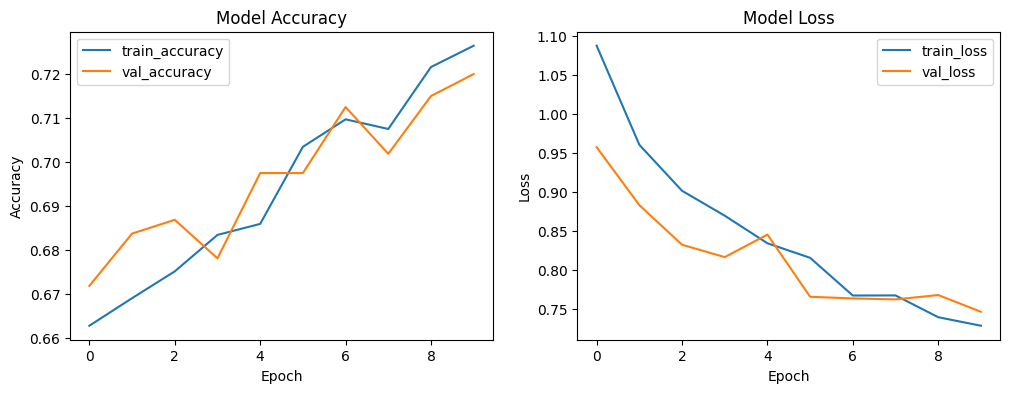

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the neural network architecture
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Get the input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

# Create the model
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

/Users/andreshofmann/.pyenv/versions/3.12.2/envs/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 27s 129ms/step - accuracy: 0.6398 - loss: 1.2212 - val_accuracy: 0.6719 - val_loss: 0.9596
Epoch 2/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 29s 143ms/step - accuracy: 0.6594 - loss: 1.0116 - val_accuracy: 0.6756 - val_loss: 0.8920
Epoch 3/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 29s 146ms/step - accuracy: 0.6664 - loss: 0.9285 - val_accuracy: 0.6737 - val_loss: 0.8634
Epoch 4/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accuracy: 0.6736 - loss: 0.9023 - val_accuracy: 0.6806 - val_loss: 0.8910
Epoch 5/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 140ms/step - accuracy: 0.6809 - loss: 0.8625 - val_accuracy: 0.6887 - val_loss: 0.7831
Epoch 6/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 29s 145ms/step - accuracy: 0.6979 - loss: 0.8162 - val_accuracy: 0.6981 - val_loss: 0.7761
Epoch 7/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accuracy: 0.6968 - loss: 0.8084 - val_accuracy: 0.7068 - val_loss: 0.7757
Epoch 8/10
201/201 ━━━━━━━━━━━━━━━━━━━━ 28s 138ms/step - accuracy: 0.7138 - loss: 0

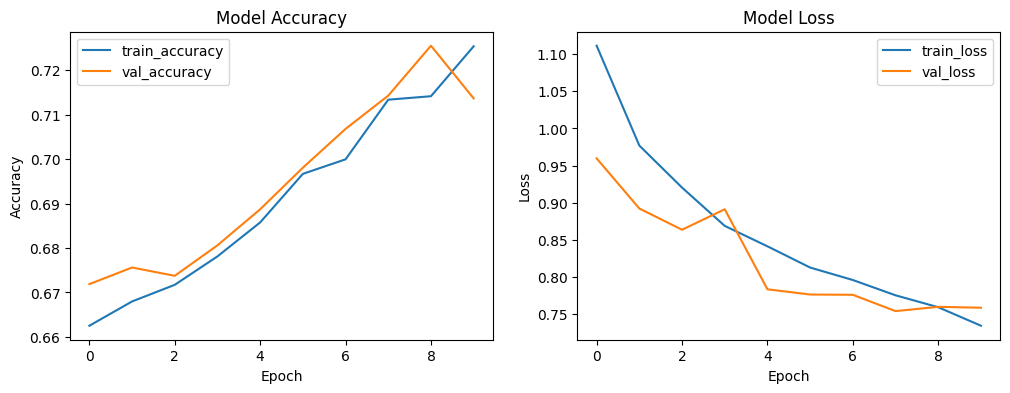

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the neural network architecture
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Get the input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

# Create the model
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

Epoch 1/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 30s 146ms/step - accuracy: 0.6431 - loss: 1.2359 - val_accuracy: 0.6719 - val_loss: 1.0017
Epoch 2/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 29s 145ms/step - accuracy: 0.6711 - loss: 0.9841 - val_accuracy: 0.6744 - val_loss: 0.9016
Epoch 3/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 32s 159ms/step - accuracy: 0.6787 - loss: 0.8981 - val_accuracy: 0.6837 - val_loss: 0.8667
Epoch 4/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 32s 162ms/step - accuracy: 0.6685 - loss: 0.8963 - val_accuracy: 0.6931 - val_loss: 0.8490
Epoch 5/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 33s 167ms/step - accuracy: 0.6805 - loss: 0.8696 - val_accuracy: 0.6875 - val_loss: 0.8387
Epoch 6/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 34s 170ms/step - accuracy: 0.6962 - loss: 0.8350 - val_accuracy: 0.7018 - val_loss: 0.8188
Epoch 7/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 33s 162ms/step - accuracy: 0.7093 - loss: 0.7935 - val_accuracy: 0.7199 - val_loss: 0.7885
Epoch 8/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 33s 164ms/step - accuracy: 0.7157 - loss: 0

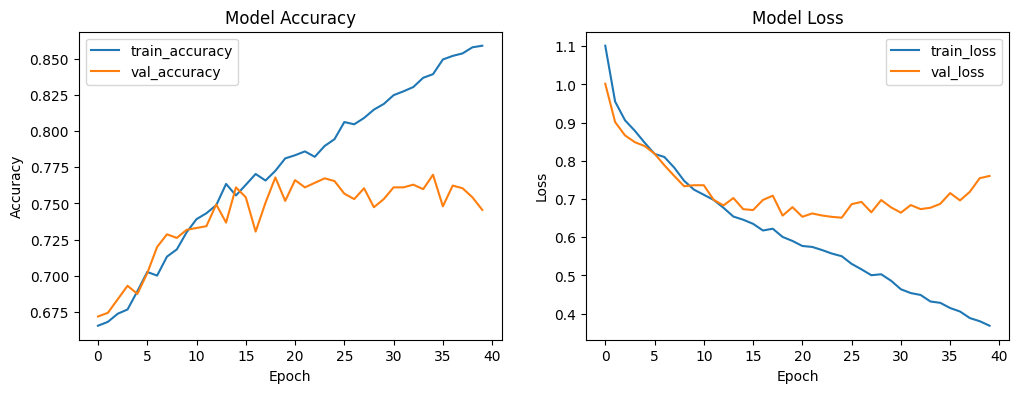

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the neural network architecture
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Get the input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

# Create the model
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

Epoch 1/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 42s 203ms/step - accuracy: 0.6651 - loss: 1.1251 - val_accuracy: 0.6794 - val_loss: 0.8948
Epoch 2/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 38s 190ms/step - accuracy: 0.6749 - loss: 0.9211 - val_accuracy: 0.7130 - val_loss: 0.8518
Epoch 3/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 41s 202ms/step - accuracy: 0.7044 - loss: 0.8255 - val_accuracy: 0.7074 - val_loss: 0.8005
Epoch 4/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 42s 211ms/step - accuracy: 0.7109 - loss: 0.7808 - val_accuracy: 0.7274 - val_loss: 0.7524
Epoch 5/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - accuracy: 0.7270 - loss: 0.7507 - val_accuracy: 0.7355 - val_loss: 0.7435
Epoch 6/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 42s 210ms/step - accuracy: 0.7456 - loss: 0.7086 - val_accuracy: 0.7243 - val_loss: 0.7305
Epoch 7/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 43s 215ms/step - accuracy: 0.7545 - loss: 0.6765 - val_accuracy: 0.7205 - val_loss: 0.7249
Epoch 8/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 38s 188ms/step - accuracy: 0.7488 - loss: 0

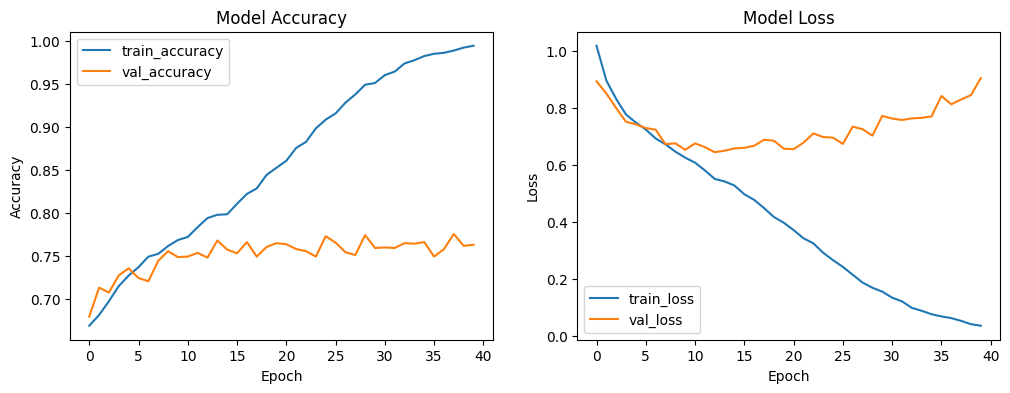

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Define the neural network architecture
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='tanh', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='tanh'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='tanh'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='tanh'),
        MaxPooling2D((2, 2)),
        Conv2D(512, (3, 3), activation='tanh'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Get the input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

# Create the model
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd


# Define the neural network architecture
def create_cnn_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='tanh', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='tanh'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='tanh'),
        MaxPooling2D((2, 2)),
        Conv2D(256, (3, 3), activation='tanh'),
        MaxPooling2D((2, 2)),
        Conv2D(512, (3, 3), activation='tanh'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(num_classes, activation='softmax')
    ])
    return model

# Get the input shape and number of classes
input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

# Create the model
model = create_cnn_model(input_shape, num_classes)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.01), 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.2)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f"Test accuracy: {test_accuracy * 100:.2f}%")

# Plot training history
import matplotlib.pyplot as plt

# Accuracy plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

/Users/andreshofmann/.pyenv/versions/3.12.2/envs/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 35s 168ms/step - accuracy: 0.5835 - loss: 5.3637 - val_accuracy: 0.6719 - val_loss: 1.1342
Epoch 2/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 34s 171ms/step - accuracy: 0.6660 - loss: 1.1948 - val_accuracy: 0.6719 - val_loss: 1.1233
Epoch 3/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 34s 170ms/step - accuracy: 0.6727 - loss: 1.1639 - val_accuracy: 0.6719 - val_loss: 1.1310
Epoch 4/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 34s 170ms/step - accuracy: 0.6697 - loss: 1.1324 - val_accuracy: 0.6719 - val_loss: 1.1204
Epoch 5/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 33s 165ms/step - accuracy: 0.6646 - loss: 1.1492 - val_accuracy: 0.6719 - val_loss: 1.1177
Epoch 6/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 33s 165ms/step - accuracy: 0.6721 - loss: 1.1368 - val_accuracy: 0.6719 - val_loss: 1.1184
Epoch 7/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 33s 165ms/step - accuracy: 0.6672 - loss: 1.1383 - val_accuracy: 0.6719 - val_loss: 1.1181
Epoch 8/40
201/201 ━━━━━━━━━━━━━━━━━━━━ 34s 168ms/step - accuracy: 0.6749 - loss: 1

KeyboardInterrupt: 